# TensAIR: Real-Time Training of Distributed Artificial Neural Networks

<p>
<div style="text-align: justify"> TensAIR is a system designed for real-time training from data streams. TensAIR's dataflow can be visualized with a graph, in which vertices represent operators and edges how they communicate among themselves. One fundamental characteristic from TensAIR is that it implements TensorFlow within the Asynchronous Iterative Routing (<a href="https://gitlab.uni.lu/mtheobald/AIR">AIR</a>) stream engine. This enables TensAIR to scale-out the training and inference of ANN models in an asyncrhonous and descentralized manner. </div>

<cite>Tosi, Mauro DL, Vinu E. Venugopal, and Martin Theobald (2024). “TensAIR: RealTime Training of Neural Networks from Data-streams”. In: Proceedings of the 8th international conference on machine learning and soft computing.</cite>
    
<url>https://github.com/maurodlt/TensAIR</url>

### Characteristics:

- Train ANN models from data streams
- Asynchronous
- Descentralized
- Passive Concept Drift Adaptation
- High Performance
    - Implemented in C++
    - Uses MPI for Communication

### Extensions for this demonstration:

- Python Interface
- Active Concept Drift Adaptation
    - Uses <a href="https://arxiv.org/abs/2305.11942">OPTWIN</a> concept drift detector

### TensAIR dataflow
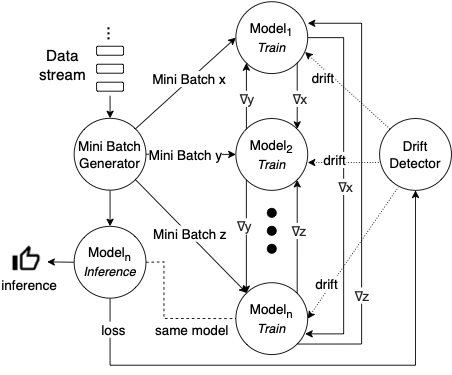

### TensAIR use-case

1. Create and save TensorFlow model
2. Create python script with 'next_message(mini_batch_size)' function
3. Define TensAIR dataflow
4. Run TensAIR

## Installing TensAIR

### Required Softwares:
- CMake
- MPICH or OpenMPI 
- Python >= 2.8
    - pybind11
    - mpi4py
    - matplotlib
    - tensorflow <= 2.9.2 and >=2.4.0
- <a href="https://www.tensorflow.org/install/lang_c">TensorFlow C API</a> (same version as the one installed previsouly)


### Building TensAIR
```bash
git clone https://github.com/maurodlt/TensAIR.git
cd TensAIR
source config.sh
mkdir Release
cd Release
cmake ..
make all -j$(nproc)


## 1. Model Creation

To create a TensAIR model, one must create a normal TensorFlow model but extending tensair_aux.TensAIR instead of tf.keras.Model.

In this demonstration, we will create a simple CNN to train CIFAR-10. Thus, we use the model available on https://www.tensorflow.org/tutorials/images/cnn

Additionally, we add the freeze_layers function, which we will use to freeze all convulutional layers after training, which will enable us to fine tune only the Dense layer in real-time. This will guarantee a faster convergence and, consequently, concept-drift adaptation.

In [1]:
import tensair_aux as tensair
import tensorflow as tf

In [2]:
class Cifar_CNN(tensair.TensAIR):
    def __init__(self):
        super(Cifar_CNN, self).__init__()
        self.l1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3))
        self.l2 = tf.keras.layers.MaxPooling2D((2, 2))
        self.l3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.l4 = tf.keras.layers.MaxPooling2D((2, 2))
        self.l5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.l6 = tf.keras.layers.Flatten()
        self.l7 = tf.keras.layers.Dense(64, activation='relu')
        self.l8 = tf.keras.layers.Dense(10)
        
    @tf.function
    def call(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        x = self.l6(x)
        x = self.l7(x)
        x = self.l8(x)
        return x
    
    @tf.function
    def freeze_layers(self):
        for layer in self.layers:
            layer.trainable = False
    
        # Unfreeze the last two layers
        self.l7.trainable = True
        self.l8.trainable = True

### Pre-training model

Here we will pre-train our CNN using the CIFAR-10 dataset

In [3]:
from tensorflow.keras import datasets

In [4]:
#Download Cifar dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [5]:
#compile TensorFlow model as usual
model = Cifar_CNN()

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam()

model.compile(optimizer=opt,
              loss=loss,
              metrics=['accuracy'])

In [6]:
#Define training parameters
batch_size = 128
epochs = 20

In [7]:
history = model.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_images, test_labels))

Epoch 1/20


2024-03-28 15:00:26.754388: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


111/391 [=======>......................] - ETA: 6s - loss: 1.9388 - accuracy: 0.2953

KeyboardInterrupt: 

### Prepare model for deployment

To prepare the model for deployment, we fine tune only its last two layers in real-time. Thus, we freeze the first layers (optional).

Then, we re-compile the model using SGD as optimizer.

We later initialize the TF graph making a test prediction.

At last, we initialize the gradients that will be broadcasted via TensAIR (mandatory)

In [8]:
model.freeze_layers()

In [9]:
loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.SGD()

model.compile(optimizer=opt,
              loss=loss,
              metrics=['accuracy'])

In [10]:
x = tf.zeros((1, 32, 32, 3), dtype=float)
model.predict(x)

1/1 [==============================] - 0s 51ms/step


array([[-0.73753023, -0.7851777 ,  0.34494817,  0.27157107,  0.6645803 ,
         0.24129863,  0.7786367 ,  0.28647095, -1.0467023 , -0.7258347 ]],
      dtype=float32)

In [11]:
model.init_delta(model.trainable_weights)

### Save Model

To save the model, we simply define the dimentions and types of the input tensors used during training, a pass those (along with the model) to the tensair.define_signatures function) to obtain the signature of the functions

At last, we save the model on the desired location uwing the signatures previously obtained

In [12]:
import os

In [13]:
input_tensors_dims = [[None,32,32,3],[None]]
input_tensors_types = [tf.float32,tf.int32]
input_tensors_structure = (1,1)

In [14]:
signatures = tensair.define_signatures(model, input_tensors_dims,input_tensors_types,input_tensors_structure)

In [15]:
tensair_path = os.environ.get("TENSAIR_PATH")

In [16]:
model.save(tensair_path+ "/data/demo/cifar_demonstration2.tf", save_format="tf", signatures=signatures)

INFO:tensorflow:Assets written to: /Users/mauro.dalleluccatosi/Documents/GitHub-personal/TensAIR/data/demo/cifar_demonstration2.tf/assets


INFO:tensorflow:Assets written to: /Users/mauro.dalleluccatosi/Documents/GitHub-personal/TensAIR/data/demo/cifar_demonstration2.tf/assets


## 2. Data Pre-processing

Our objective here is to create a python script with the following function function, which receive the minibatch size as input and return a byte message with the next mini batch that should be used for training the CNN model, the message minibatch should respect the following format:

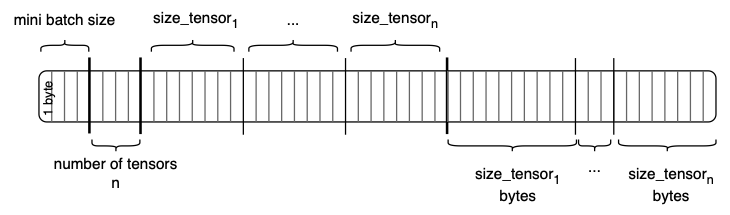

In [17]:
%%writefile demonstration_next_message.py

from tensorflow.keras import datasets
import random
import struct
import numpy as np

Overwriting demonstration_next_message.py


In [18]:
%%writefile -a demonstration_next_message.py

#Download Cifar dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

num_inputs = 2  #images & labels

drifts_epochs = 10  #generate a drift every drifts_epochs epochs

epochs = 0 #currrent epoch

global_counter = 0 #mini_batch number within current epoch

Appending to demonstration_next_message.py


In [19]:
%%writefile -a demonstration_next_message.py

def shuffle_dataset():
    global train_images, train_labels
    global epochs
    global drifts_epochs
    global global_counter
    
    global_counter = 0
    epochs+=1
    combined = list(zip(train_images, train_labels))
    random.shuffle(combined)
    # Unzip them back into separate lists
    train_images, train_labels = zip(*combined)
    
    #perform concept drift after drifts_epochs epochs
    if epochs % drifts_epochs == 0:
        #select two different labels at random
        x = random.randint(0, 9)
        y = random.randint(0, 9)
        while x == y:
            y = random.randint(0, 9)
            
        # Iterate through each NumPy array in the sequence and swap 2s with 7s and vice versa
        for arr in train_labels:
            # Find indexes of x and y
            idx_x = np.where(arr == x)
            idx_y = np.where(arr == y)

            # Swap x with y and vice versa
            arr[idx_x] = y
            arr[idx_y] = x
    return


shuffle_dataset()

Appending to demonstration_next_message.py


In [20]:
%%writefile -a demonstration_next_message.py

#returns message with format:
'''
    mini_batch_size (4 bytes)
    num_inputs (4 bytes)
    size_inputs_1 (8 bytes)
    ...
    size_inputs_num_inputs ( 8 bytes)
    input_1 (size_inputs_1 byes)
    input_size_inputs_num_inputs (size_inputs_num_inputs bytes) 
'''
def next_message(mini_batch_size):
    global global_counter
    global train_images
    global train_labels
    global num_inputs
    
    message = mini_batch_size.to_bytes(4, 'little') #add minibatch size to message
    message += num_inputs.to_bytes(4, 'little') #add num_inputs to message
    
    size_inputs = [mini_batch_size*4*32*32*3, mini_batch_size*4] # define size of inputs
    
    #add size of inputs to message
    for inp in size_inputs: 
        message += inp.to_bytes(8, 'little') 
    
    #check for end of training images
    if mini_batch_size*(global_counter+1) > len(train_images)-1:
        shuffle_dataset()
    
    #define minibatch
    minibatch_images = np.array(train_images[mini_batch_size*global_counter:mini_batch_size*(global_counter+1)], dtype=np.float32)
    minibatch_labels = np.array(train_labels[mini_batch_size*global_counter:mini_batch_size*(global_counter+1)], dtype=np.int32)
    
    #serialize images
    message += minibatch_images.tobytes()

    #serialize labels
    message += minibatch_labels.tobytes()
    
    global_counter +=1
    return message

Appending to demonstration_next_message.py


## 3. TensAIR dataflow

In [21]:
%%writefile demonstration_dataflow.py

from mpi4py import MPI
import tensair_py
import os

Overwriting demonstration_dataflow.py


In [22]:
%%writefile -a demonstration_dataflow.py

comm = MPI.COMM_WORLD
tensair_path = os.environ.get("TENSAIR_PATH")

Appending to demonstration_dataflow.py


In [23]:
%%writefile -a demonstration_dataflow.py

mini_batch_size = 128
msg_sec = 100    
init_code= tensair_path + "/Examples/DEMO/demonstration_next_message.py"
event_generator = tensair_py.UDF_EventGenerator(mpi_comm=comm, tag=1, mini_batch_size=mini_batch_size, msg_sec=msg_sec, init_code=init_code)

Appending to demonstration_dataflow.py


In [24]:
%%writefile -a demonstration_dataflow.py

inputMaxSize = 4 + 4 + (8*2) + (4*mini_batch_size*32*32*3) + (4*mini_batch_size)
gradientsMaxSize = 120 + (4*((64*10) + (10) + (1024*64) + (64)))
window_size = max(inputMaxSize, gradientsMaxSize)
saved_model_dir = tensair_path + "/data/demo/cifar_demonstration.tf" 
model = tensair_py.TensAIR(mpi_comm=comm, tag=2, window_size=window_size, saved_model_dir=saved_model_dir)

Appending to demonstration_dataflow.py


In [25]:
%%writefile -a demonstration_dataflow.py

drift_detector = tensair_py.OPTWIN_drift_detector(mpi_comm=comm, tag=3)

Appending to demonstration_dataflow.py


In [26]:
%%writefile -a demonstration_dataflow.py

operators = [event_generator, model, drift_detector]
links = [[0,1],[1,1],[1,2],[2,1]]
basic_dataflow = tensair_py.BasicDataflow(mpi_comm=comm, operators=operators, links=links)
print("Starting dataflow")
basic_dataflow.streamProcess()

Appending to demonstration_dataflow.py


## 4. Running TensAIR

### Command Line

In [29]:
%%sh
mpirun -np 2 python demonstration_dataflow.py

2024-03-27 17:59:09.741374: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /Users/mauro.dalleluccatosi/Documents/GitHub-personal/TensAIR/data/demo/cifar_demonstration.tf
2024-03-27 17:59:09.751404: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-03-27 17:59:09.751413: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /Users/mauro.dalleluccatosi/Documents/GitHub-personal/TensAIR/data/demo/cifar_demonstration.tf
2024-03-27 17:59:09.758939: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-03-27 17:59:09.761067: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-03-27 17:59:09.763612: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-27 17:59:09.816331: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /User

TF_LoadSessionFromSavedModel OK


2024-03-27 17:59:30.660328: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /Users/mauro.dalleluccatosi/Documents/GitHub-personal/TensAIR/data/demo/cifar_demonstration.tf
2024-03-27 17:59:30.662444: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-03-27 17:59:30.662454: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /Users/mauro.dalleluccatosi/Documents/GitHub-personal/TensAIR/data/demo/cifar_demonstration.tf
2024-03-27 17:59:30.669030: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-03-27 17:59:30.670086: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-03-27 17:59:30.671197: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-27 17:59:30.707690: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /User

TF_LoadSessionFromSavedModel OK
Error while terminating subprocess (pid=38208): 


## Visualizing Results

In [27]:
%matplotlib ipympl
from matplotlib.animation import FuncAnimation
from functools import partial
import matplotlib.pyplot as plt
import os
import tensair_aux as tensair

tensair_path = os.environ.get("TENSAIR_PATH")
outputfile = tensair_path + "/output/0.csv"

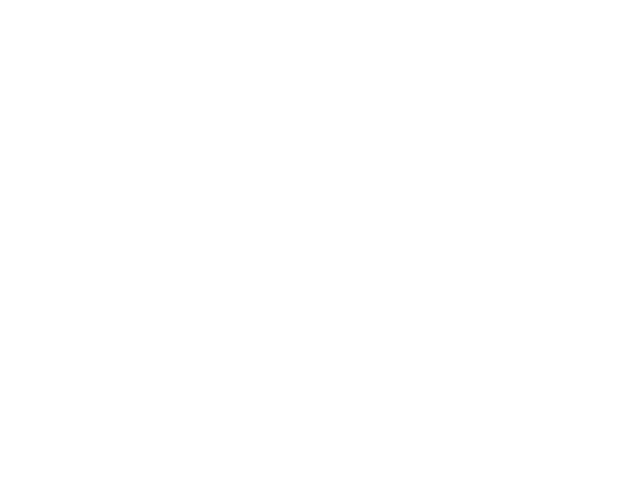

In [28]:
ani = FuncAnimation(plt.gcf(), partial(tensair.animate, outputfile=outputfile), interval=1000)

plt.show()

In [33]:
ani.pause()